This is my cryptocurrency backtesting system. Details to follow soon.
To do:
- how do I bring in the whole universe of coins on coingecko?
- how do I screen them for market cap size right at the beginning? - can I do this to save myself bringing in the entire universe before screening it?
- can i screen for liquidity somehow? (or by volume?)
- how far back can I go on coingecko? Or do I need to look at another data source?
- can i find a source for things like TVL?

In [17]:
############ IMPORTS
from typing import NamedTuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import os.path
import backtest_crypto as bt
from pycoingecko import CoinGeckoAPI
import datetime
import time
from tabulate import tabulate

In [40]:
############ INPUTS
#cost = 0.000
frequency = 365.0

We now pull data from CoinGecko, and convert the data into a dict of dataframes:

In [41]:
cg = CoinGeckoAPI()
# set the start and end date of the data we want and convert format of dates
datetime1 = datetime.datetime(2017, 1, 1, 10, 20)
datetime2 = datetime.datetime(2021, 5, 15, 10, 20)
from_dateTime = time.mktime(datetime1.timetuple())
to_dateTime = time.mktime(datetime2.timetuple())

#choose which coins to include in the investable universe that we will choose the portfolio from
portfolio = ['bitcoin', 'ethereum', 'solana', 'venus', 'binancecoin', 'cardano','ripple', 'polkadot','chainlink', 'fantom', 'matic-network', 'aave']
data={}
for name in portfolio:
    try: 
        data[name] = cg.get_coin_market_chart_range_by_id(
            id=name, 
            vs_currency='usd', 
            from_timestamp=from_dateTime, 
            to_timestamp=to_dateTime 
            )
    except:
        print(name, " not found")

# from a dict of lists, create a dict of dataframes
for name in portfolio:
    for x in data[name].keys(): 
        data[name][x] = pd.DataFrame.from_records(data[name][x], 
        exclude=['Date'], 
        columns=['Date', name], 
        index=['Date']
        )
        data[name][x] = data[name][x].set_index(pd.to_datetime(data[name][x].index, unit='ms'))

#concatenate these dataframes so that all tickers appear as column headers in one dataframe
inputs = {}
for x in data[name].keys():
    inputs[x] = data[portfolio[0]][x]
    for i in range(len(portfolio)-1):
        inputs[x] = pd.concat([inputs[x], 
        data[portfolio[i+1]][x]], 
        axis=1
        )

#print(inputs)
print(tabulate(inputs, headers='keys', tablefmt='psql'))
print(inputs['market_caps'])
inputs_not_to_shift = ['prices','market_caps','total_volumes']
inputs_to_shift=[item for item in inputs if item not in inputs_not_to_shift]

+---------------+---------------+-----------------+
| prices        | market_caps   | total_volumes   |
|---------------+---------------+-----------------|
| bitcoin       | bitcoin       | bitcoin         |
| ethereum      | ethereum      | ethereum        |
| solana        | solana        | solana          |
| venus         | venus         | venus           |
| binancecoin   | binancecoin   | binancecoin     |
| cardano       | cardano       | cardano         |
| ripple        | ripple        | ripple          |
| polkadot      | polkadot      | polkadot        |
| chainlink     | chainlink     | chainlink       |
| fantom        | fantom        | fantom          |
| matic-network | matic-network | matic-network   |
| aave          | aave          | aave            |
+---------------+---------------+-----------------+
                 bitcoin      ethereum        solana         venus  \
Date                                                                 
2017-01-02  1.638793e+10  7.

In [42]:
# create a data object 'd' using backtest.py
d = bt.Data(inputs, 
            inputs_to_shift, 
            months_delay_data=3, 
            start=0, 
            delist_value=1
            )
# create a dataframe with initial portfolio allocations (all 1's)
init_pos1 = pd.DataFrame(1, 
            index=d.basic_data['prices'].index, 
            columns=d.basic_data['prices'].columns
            )
#print(init_pos1)

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
       CAGR     Std Dev      Sharpe    Sortino    GPR  Max Drawdown    Best mth    Worst mth    Win mths
-----  -------  ---------  --------  ---------  -----  --------------  ----------  -----------  ----------
BAH    131.73%  82.61%        0.247       1.27  0.256  -86.94%         26.64%      -39.12%      56.88%
alsi   367.07%  89.81%        0.38        2.46  0.481  -78.01%         39.75%      -40.08%      44.56%
mom    773.73%  146.80%       0.377       2.87  0.481  -80.18%         139.21%     -48.36%      51.15%
mom_2  773.73%  146.80%       0.377       2.87  0.481  -80.18%         139.21%     -48.36%      51.15%


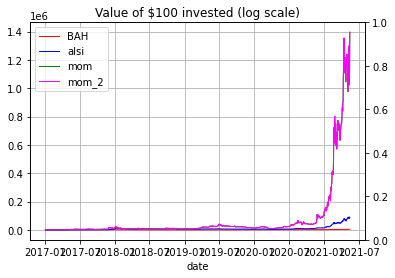

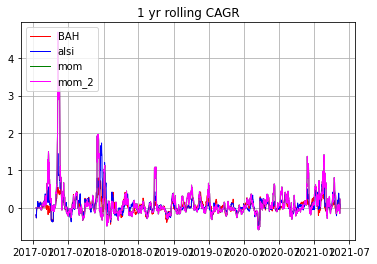

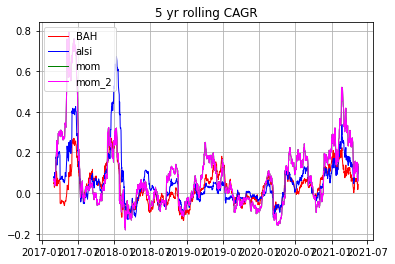

In [43]:

ret={}  
mc=bt.Mkt_cap_scr(threshold=1000000000) #screens out anything with market cap < $1,000,000,000
mw=bt.Mkt_cap_weights() #does market cap weighting

#print("Creating QM object")
#QM_object = bt.QM(threshold=1000, scr2_perc = 0.15, scr3_perc = 0.6, upper_limit=0.2)
#QM_object.backtest(init_pos= init_pos1, data = d) #, rebalance = 'M', #Q-NOV, Q-DEC, Q-OCT                        
#ret['QM'] = QM_object.calc_ret(price_data= d.basic_data['prices'])

#ret['QM+QV'] = (QM_object.calc_ret(price_data= d.basic_data['prices']) + QV_object.calc_ret(price_data= d.basic_data['prices'])  )/2.0

BAH_instance = bt.BAH() #don't screen at all, just hold all tickers
BAH_instance.backtest(mc.run(init_pos1,data=d), data=d) #run the backtest with buy-and-hold, market cap screen
ret['BAH'] = BAH_instance.calc_ret(d.basic_data['prices'])   # calculate returns

#at the moment this takes the last 12 periods momentum, but excludes the last one - this was initially meant to be for stocks, so it was looking back a year. However, we're now looking at daily prices, so not sure the number 12 has any relevance - how can I check what might be relevant? Need to almost start this investigation from scratch for the crypto markets...
mom_instance = bt.Mom(scr_perc = 0.15) # screen for the top 15% of the universe by momentum
mom_instance.run(mc.run(init_pos1,data=d), data=d) # run the actual backtest, from init_pos1, with market cap screen
ret['mom'] = mom_instance.calc_ret(d.basic_data['prices'])   #calculate returns

BAH_object = bt.BAH()
mw.run(BAH_object.backtest(mc.run(init_pos1,data=d), data=d), data=d)
mw.final_positions = bt.limit_pos_size(mw.final_positions)
ret['alsi'] = mw.calc_ret(d.basic_data['prices'])

mom_object = bt.Mom(scr_perc = 0.15)
mw.run(mom_object.run(mc.run(init_pos1,data=d), data=d), data=d)
mw.final_positions = bt.limit_pos_size(mw.final_positions)
ret['mom_2'] = mw.calc_ret(d.basic_data['prices'])

#need daily (or hourly?) prices to run fip...
# #fip_object = bt.Fip(scr_perc = 0.6)
#fip_object.run(mc.run(init_pos1,data=d), data=d)
#ret['fip'] = fip_object.calc_ret(d.basic_data['prices'])

metrics=(['BAH','alsi','mom','mom_2']) #'QV', 'QV_fin',,'QM','alsi'

bt.tabulate_results(ret, metrics, frequency=365.0, risk_free = 0.07) # risk free rate is per annum
bt.plot_returns(ret, metrics)
bt.plot_CAGR(ret, metrics, 1)
bt.plot_CAGR(ret, metrics, 5)